In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import visutils
import camutils as cam
import selectpoints
import meshutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy
import trimesh

# 1. Calibrate
Utilize the calibrate.py script from assignment 2 to get accurate intrinsic parameters for the scanner cameras using the images in the calib_jpg_u directory. Also use your calibration method (or possibly the opencv calibration function) to determine the extrinsic parameters.

In [4]:
# Individual intrinsic parameters
fx =  1405.3079107410365
fy =  1403.8940216103742
cx =  962.1673692606323
cy =  590.915956814067

In [5]:
favg = (fx+fy)/2

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = cam.Camera(f=favg,c=np.array([[cx,cy]]).T,t=np.array([[0,0,0]]).T, R=cam.makerotation(0,0,0))
camR = cam.Camera(f=favg,c=np.array([[cx,cy]]).T,t=np.array([[0,0,0]]).T, R=cam.makerotation(0,0,0))

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result
params_init = np.array([0,0,0,0,0,-2]) 

camL = cam.calibratePose(pts3,pts2L,camL,params_init)
camR = cam.calibratePose(pts3,pts2R,camR,params_init)
# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
# pts3r = cam.triangulate(pts2L,camL,pts2R,camR)

# # Display the reprojected points overlayed on the images to make 
# # sure they line up
# plt.rcParams['figure.figsize']=[15,15]
# pts2Lp = camL.project(pts3)
# plt.imshow(imgL)
# plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
# plt.plot(pts2L[0,:],pts2L[1,:],'rx')
# plt.show()

# pts2Rp = camR.project(pts3)
# plt.imshow(imgR)
# plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
# plt.plot(pts2R[0,:],pts2R[1,:],'rx')ppi
# plt.show()

# 2. Reconstruct
Modify your reconstruct function from assignment 4 to make use of the two color images collected from each camera (i.e., color_C0_00/01). Compute an object mask by taking the difference of the object color image and the background image and thresholding the difference to determine the set of pixels that belong to the foreground object. You should combine this mask along with your decoding mask in order to avoid triangulating pixels that are part of the background

In [96]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR):
    """
    Simple reconstruction based on triangulating matched pairs of points
    between to view which have been encoded with a 20bit gray code.

    Parameters
    ----------
    imprefix : str
      prefix for where the images are stored

    threshold : float
      decodability threshold

    camL,camR : Camera
      camera parameters

    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)

    """
    img_backgroundLColor = plt.imread(imprefixL+"/color_C0_00.png")
    imgLColor = plt.imread(imprefixL+"/color_C0_01.png");
#     print(imprefixL+"/color_C0_00.png")
    
    img_backgroundRColor = plt.imread(imprefixR+"/color_C1_00.png")
    imgRColor = plt.imread(imprefixR+"/color_C1_01.png");

    imgL = np.mean(imgLColor, axis = 2)
    img_backgroundL = np.mean(img_backgroundLColor, axis = 2)
    maskL = np.zeros((imgL.shape[0], imgL.shape[1]))

    imgR = np.mean(imgRColor, axis = 2)
    img_backgroundR = np.mean(img_backgroundRColor, axis = 2)
    maskR = np.zeros((imgR.shape[0], imgR.shape[1]))

    

    CLh,maskLh = cam.decode(imprefixL+"/frame_C0_",0,threshold)
    CLv,maskLv = cam.decode(imprefixL+"/frame_C0_",20,threshold)
    CRh,maskRh = cam.decode(imprefixR+"/frame_C1_",0,threshold)
    CRv,maskRv = cam.decode(imprefixR+"/frame_C1_",20,threshold)
    
    threshold = 0.001
    for i in range (imgL.shape[0]):
                for j in range(imgL.shape[1]):
                    if (abs(imgL[i,j] - img_backgroundL[i,j]) >= threshold):
                        maskL[i,j] = 1
                    else:
                         maskL[i,j] = 0
                    if (abs(imgR[i,j] - img_backgroundR[i,j]) >= threshold):
                        maskR[i,j] = 1
                    else:
                         maskR[i,j] = 0

    CL = CLh + 1024*CLv
    maskL = maskLh*maskLv*maskL
    CR = CRh + 1024*CRv
    maskR = maskRh*maskRv*maskR
    
    
    plt.imshow(CL*maskL)
    plt.title(imprefixL + "left")
    plt.show()

    plt.imshow(CR*maskR)
    plt.title(imprefixR + "right")
    plt.show()

    h = CR.shape[0]
    w = CR.shape[1]

    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]

    _,submatchR,submatchL = np.intersect1d(CRgood,CLgood,return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))

    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    pts3 = cam.triangulate(pts2L,camL,pts2R,camR)
    color= []
    
    return pts2L,pts2R,pts3



loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



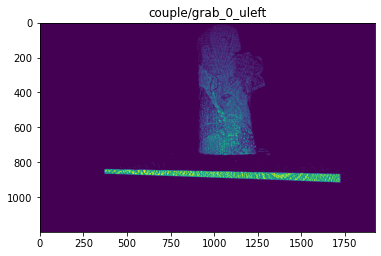

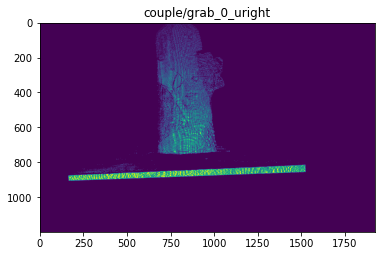

In [97]:
resultfile = 'pts_value.pickle'
fid = open(resultfile, "wb" ) 
threshold = 0.05
results = {}
for x in range (1):
    if (x!= 5):
        imprefix = "couple/grab_"+str(x)+"_u"
        pts2L,pts2R,pts3 = reconstruct(imprefix,imprefix,threshold,camL,camR)
        results[x] = {"pts2L": pts2L, "pts2R": pts2R, "pts3": pts3}
pickle.dump(results,fid)
fid.close()

# 3. Mesh
Since we are going to generate meshes for many different scans, encapsulate your mesh generation code in a function. That function should take as input the directory of scan images along with any threshold / cleanup parameters which you might want to adjust differently for different scans. You probably want to store the results of this computation (e.g., pts2L/R,pts3,colors) in a pickle file so the simplest approach may be to also pass in the name of the file in which to store the results

In [10]:
# Mesh cleanup parameters
def box_limit(boxlimit, pts3, pts2L, pts2R):
    index =np.where((pts3[0,:] <= boxlimit[0]))[0]
    index = np.concatenate((index, np.where((pts3[0,:] >= boxlimit[1]))[0]))
    index = np.concatenate((index, np.where((pts3[1,:] <= boxlimit[2]))[0]))
    index = np.concatenate((index, np.where((pts3[1,:] >= boxlimit[3]))[0]))
#     print(boxlimit[3])
    index = np.concatenate((index, np.where((pts3[2,:] <= boxlimit[4]))[0]))
    index = np.concatenate((index, np.where((pts3[2,:] >= boxlimit[5]))[0]))
    pts3 = np.delete(pts3,index, axis = 1)
    pts2L = np.delete(pts2L,index, axis = 1)
    pts2R = np.delete(pts2R,index, axis = 1)
    return pts3,pts2L,pts2R

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits


# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
def triangle_pruning(tri, trithresh, pts3, pts2L, pts2R):
    
    pts3_triangles = pts3.T[tri.simplices]
    badtriangles = []
    for x in range(len(pts3_triangles)):
        row1 = pts3_triangles[x, 0]
        row2 =  pts3_triangles[x, 1]
        row3 =  pts3_triangles[x, 2]
        if (np.linalg.norm(row1-row2) >= trithresh or np.linalg.norm(row1-row3) >= trithresh or np.linalg.norm(row2-row3) >= trithresh):
                   badtriangles.append(x)
      # see if x is an index of bad triangle
      # if so, badtriangles.append(x)
#     print(len(badtriangles))
#     tri.simplices =np.delete(tri.simplices, badtriangles, 0)
    return np.delete(tri.simplices, badtriangles, 0)
def mesh(boxlimit, trithresh, pts3, pts2L, pts2R ):
#     print(boxlimit)
    pts3, pts2L, pts2R = box_limit(boxlimit, pts3, pts2L,pts2R)
    tri = scipy.spatial.Delaunay(pts2L.T)
    tri.simplices = triangle_pruning(tri, trithresh, pts3, pts2L, pts2R)
    mesh = trimesh.Trimesh(vertices=pts3.T,faces=tri.simplices[:,[0,2,1]])
    return mesh

In [80]:
fid = open('pts_value.pickle','rb')
results = pickle.load(fid)
fid.close
# fid = open('mesh_pts.pickle','wb')
# results = dict()
# visutils.vis_scene(camL,camR,results[7]["pts3"],looklength=20)

mesh0 = mesh(np.array([-15,25,0,30,-25,-15]), 1.6, results[0]["pts3"], results[0]["pts2L"],results[0]["pts2R"])
# mesh1 = mesh(np.array([-15,25,0,20,-40,0]), 1.6, results[1]["pts3"], results[1]["pts2L"],results[1]["pts2R"])
# mesh2 = mesh(np.array([-15,25,0,20,-30,-10]), 1.6, results[2]["pts3"], results[2]["pts2L"],results[2]["pts2R"])
# mesh3 = mesh(np.array([-15,25,-2,20,-30,-10]), 1.6, results[3]["pts3"], results[3]["pts2L"],results[3]["pts2R"])
# mesh4 = mesh(np.array([-10,25,0,20,-20,0]), 1.6, results[4]["pts3"], results[4]["pts2L"],results[4]["pts2R"])
# mesh6 = mesh(np.array([12.5,25,0,30,-30,0]), 1.6, results[6]["pts3"], results[6]["pts2L"],results[6]["pts2R"])

fid.close
# pts3, pts2L, pts2R = box_limit(boxlimit, results[0]["pts3"], results[0]["pts2L"],results[0]["pts2R"])
# tri = scipy.spatial.Delaunay(pts2L.T)
# tri.simplices = triangle_pruning(tri, trithresh, pts3, pts2L, pts2R)
# mesh = trimesh.Trimesh(vertices=pts3.T,faces=tri.simplices[:,[0,2,1]])
# mesh.show()

In [90]:
pts3 = results[0]["pts3"]
pts2L = results[0]["pts2L"]
pts2R = results[0]["pts2R"]
indices = []
print(pts3.shape)
print(mesh0)
for index, x in enumerate(pts3.T):
    if x not in mesh0.vertices:
        indices.append(index)
pts3 = np.delete(pts3,indices, axis = 1)
pts2L = np.delete(pts2L,indices, axis = 1)
pts2R = np.delete(pts2R,indices, axis = 1)
print(pts3.shape)
        
    

(3, 63214)
<trimesh.Trimesh(vertices.shape=(42590, 3), faces.shape=(84973, 3))>
(3, 42590)


In [94]:
imgLColor = plt.imread("couple/grab_0_u/color_C0_01.png");
color = []
for x in pts2L.T:
        color.append(imgLColor[x[1],x[0]])
color = np.array(color)

In [1]:
# mesh0.vertices
# a = [-11.74879697,   8.81911254, -24.95106735]
# for i in enumerate(pts3.T):
#     print(i[1])
# #     if i[:1]==[-11.74879697,   8.81911254, -24.95106735]:
# #         print(i[0])

# 4. Smooth
To get nice mesh results, I recommend implementing some form of mesh smoothing. The simplest approach is to compute for each 3D point the average location of that points neighbors in the mesh (i.e., those which are connected to it by some triangle). You can then replace the point coordinate with this average. You may opt to repeat this process multiple times, each time the mesh will get smoother. However, you don't want to "oversmooth" and remove too many details.

In [104]:
fid = open('mesh0.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh0)
fid.write(ply)
fid.close()
fid = open('mesh1.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh1)
fid.write(ply)
fid.close()
fid = open('mesh2.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh2)
fid.write(ply)
fid.close()
fid = open('mesh3.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh3)
fid.write(ply)
fid.close()
fid = open('mesh4.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh4)
fid.write(ply)
fid.close()
fid = open('mesh6.ply','wb+')
ply = trimesh.exchange.ply.export_ply(mesh6)
fid.write(ply)
fid.close()